# CONCRETE STRENGTH PREDICTION USING ANN

- Regression is a type of supervised machine learning algorithm used to predict a continuous label. The goal is to produce a model that represents the 'best fit' to some observed data, according to an evaluation criterion.


- In this Analysis, you will be predicting the strength of concrete using the given eight features that describe the components used in the mixture.These features are believed to be related to the final compressive strength which include the amount of cement in Kilograms per cubic meter, Blast.Furnace.Slag, Fly.Ash, water,superplasticizer, coarse aggregate, fine aggregate and aging period measured in days.

## Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import  callbacks
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns
%matplotlib inline

# for Interactive Shells
from IPython.display import display

#removing warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\Users\Dev\anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
print(tensorflow.__version__)

2.11.0


## Import Dataset

In [3]:
df = pd.read_csv('concrete_data.csv')
df.shape

(1030, 9)

The dataset contains 1030 observations accross 8 input variables and an output variable. The variable name, variable type, the measurement unit and a brief description is provided.

In [4]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


### There are 8 independent variables in training set:

- Cement: Total amount of cement it that particular sample.
- Blast Furnace Slag:  Blast furnace slag (BFS) is a byproduct of the iron and steel manufacturing process. BFS is used to improve the strength and durability of concrete.
- FlyAsh :  It improves the strength and durability of the concrete.
- Water: The optimal water content for cement is usually between 15-20% of the total cement weight. Too little water will result in a dry, crumbly mix, while too much water can lead to a weak, porous concrete.
- Superplasticizer:  Superplasticizers, also known as plasticizers or high range water reducers, are a type of admixture that is used to increase the workability of concrete without increasing the water-cement ratio.
- CoarseAggregatet:  Coarse aggregate is used for a variety of purposes, including providing strength, improving the workability of concrete, and reducing the amount of cement needed in a concrete mix.
- FineAggregate:  Similar as CoarseAggregateComponent but smaller in size.
- Age:  Age in days is a term used to describe the amount of time that has passed since the cement was mixed with water. Concrete gains strength over time and its properties can change significantly depending on the age. The most commonly used ages for testing concrete strength are 7, 14, 21, and 28 days.

### Target varibale:

- Strength:  Strength of the cement.

## Exploratory Data Analysis

In [5]:
df.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [7]:
# Summary statistics
df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


All predictors in the dataset are quantitative datatypes. Moreover, there are no missing values in the data. Lets analyse the probability distribution of the variables through a series of univariate density plots.

In [8]:
#  Getting known with the kind of distrubutions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=0.92, size=16)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.distplot(dataset[data], ax=axs[i])
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

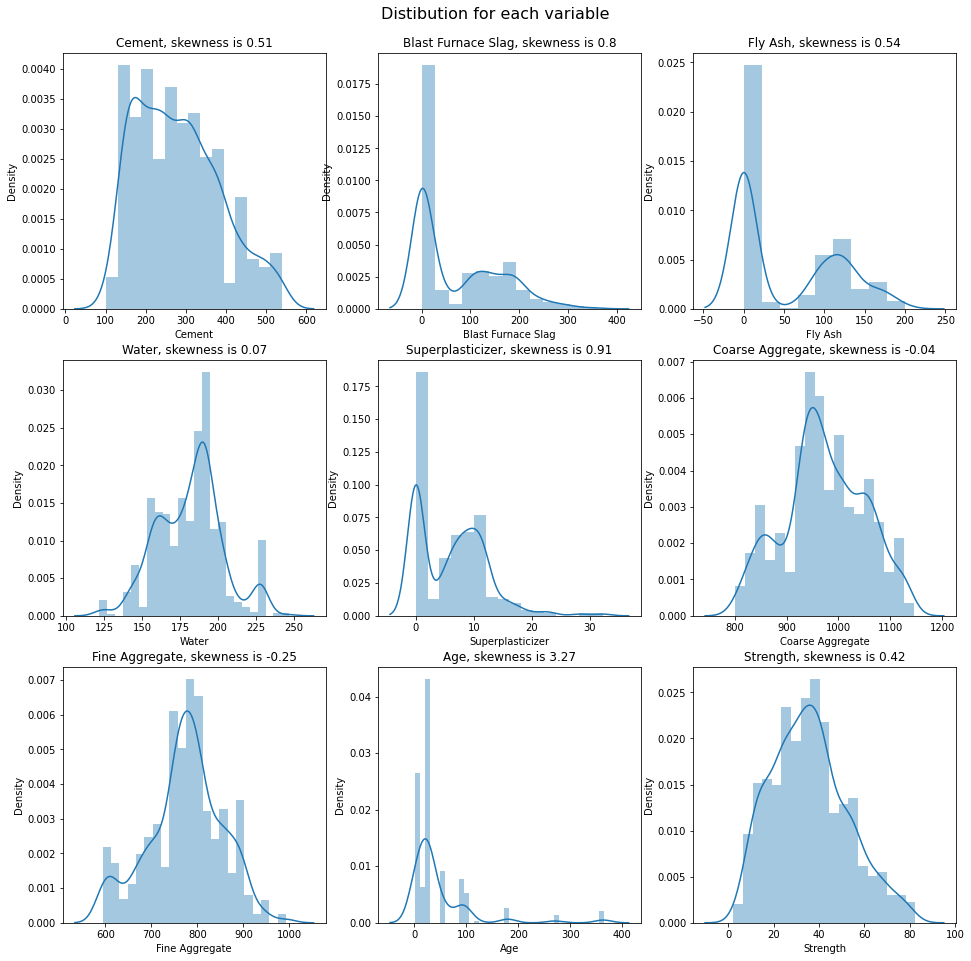

In [9]:
dist_custom(dataset=df, columns_list=df.columns, rows=3, cols=3, suptitle='Distibution for each variable')

Most variables do not follow normal distribution. It would be interesting to convert the response variable into a category of 'optimal' and 'suboptimal' in order to detect any interesting patterns between the predictors and the target variable. I'll conisder the observations at the 75th percentile or greater to be good.

In [10]:
# outliers
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,12))
    fig.suptitle(suptitle,y=0.93, size=16)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        if i % 3 == 0:
            axs[i].set_ylabel('The number of entries')
        sns.boxplot( data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data)

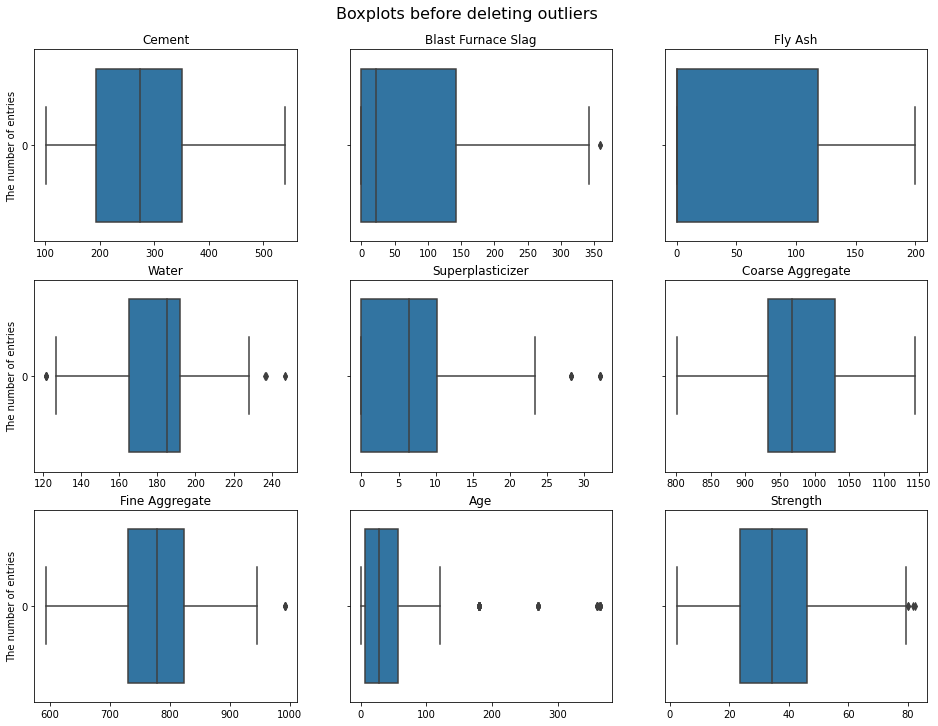

In [11]:

boxplots_custom(dataset=df, columns_list=df.columns, rows=3, cols=3, suptitle='Boxplots before deleting outliers')

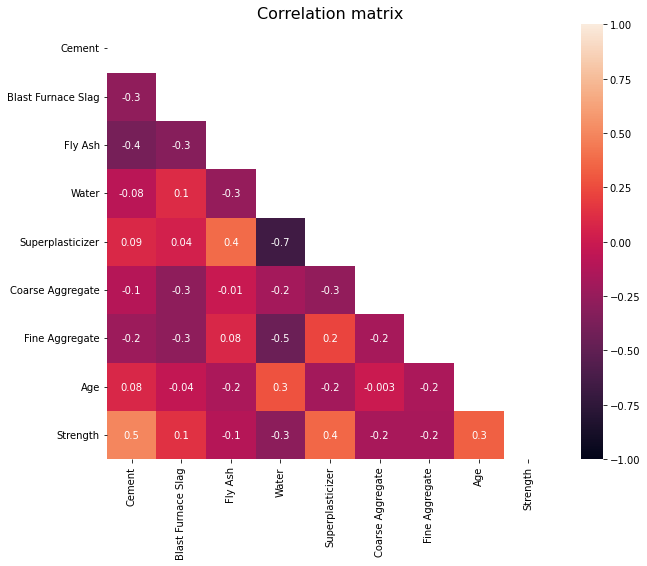

In [12]:
# calculating the correlation matrix
corr = df.corr()
matrix = np.triu(corr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmax=1.0, vmin=-1.0, 
            fmt='.1g', annot=True, mask = matrix)

plt.title('Correlation matrix', size=16)
plt.show()

The pearsons correlation assumes normality, linearity, homoscedasticity and no outliers. These assumptions are violated for most variables. This may be a potential reason as to why pearsons correlation won't detect nuances between predictors and the independent variables properly. Additionally, the relationship between inputs does seem to be largely non-linear. Nonetheless, cement, water, and superplastisizer do seem to be moderately correlated with strength.

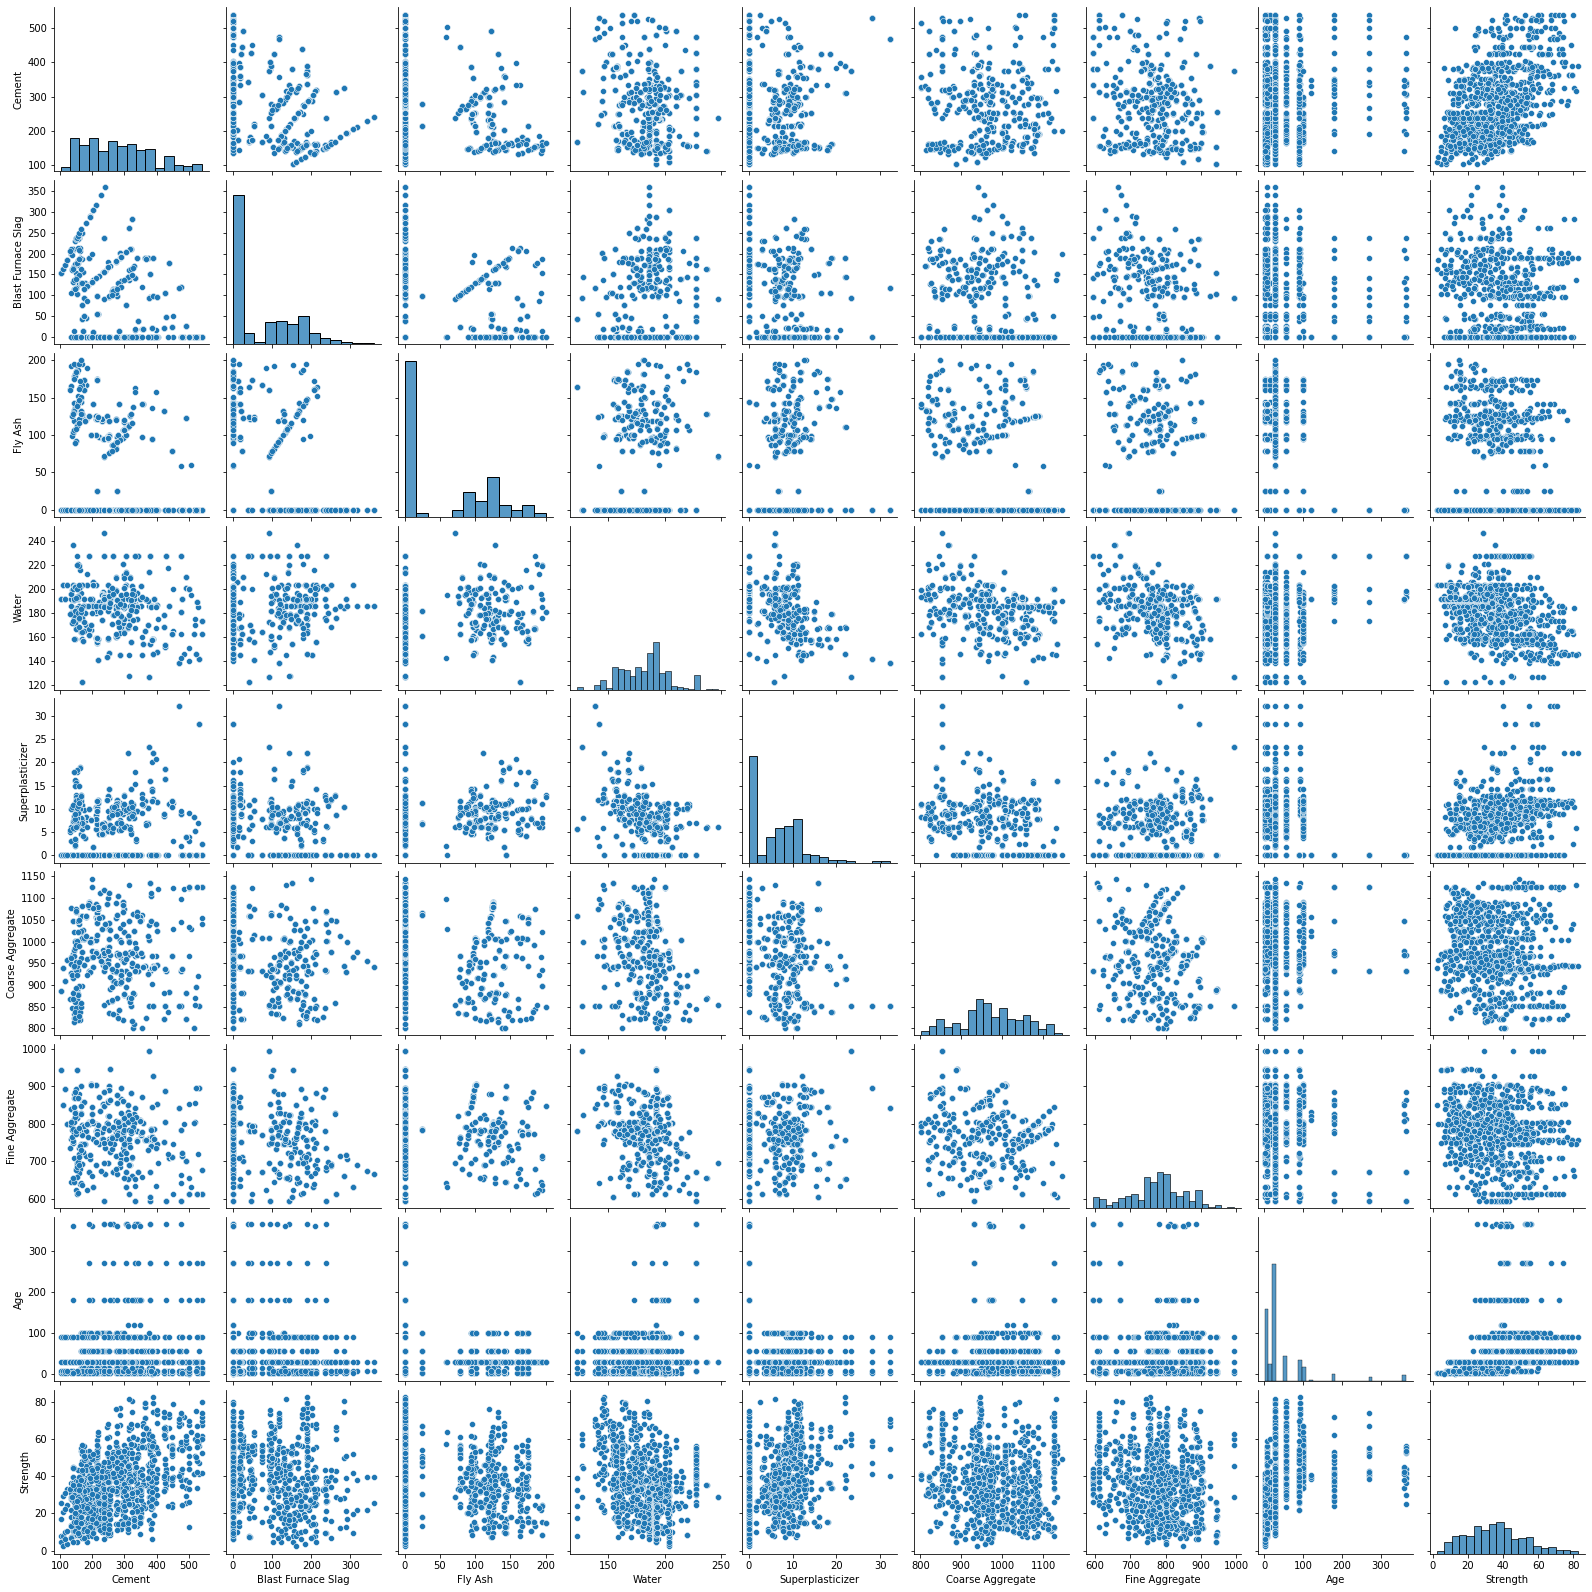

In [13]:
sns.pairplot(data=df,diag_kind="hist")
plt.show()

## Data Preprocessing

Some machine learning algorithms require features to be scaled through normalization or standardization. I will now split the dataset into training and testing and then perform standardization. This will tansform the features such that their mean and standard deviation will become 0 and 1.

In [14]:

X = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

In [15]:
# Split the dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 43)

In [16]:
# Feature Scaling 
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =sc.transform(X_test)

## Model Building using ANN

In [17]:
# Improving the ANN
from tensorflow.keras.layers import Dropout

model1 = Sequential()

# Adding the input layer and the first hidden layer
model1.add(Dense(units = 100, 
                     kernel_initializer = 'uniform', 
                     activation = 'relu', 
                     input_shape = [X_train.shape[1]]))
               

# Adding the second hidden layer
model1.add(Dense(units = 60, 
                 kernel_initializer = 'uniform', 
                 activation = 'relu'))

# Adding the Third hidden layer
model1.add(Dense(units = 80, 
                 kernel_initializer = 'uniform', 
                 activation = 'relu'))

# Adding the fourth hidden layer
model1.add(Dense(units = 90, 
                 kernel_initializer = 'uniform', 
                 activation = 'relu'))

# Adding the fifth hidden layer
model1.add(Dense(units = 100, 
                 kernel_initializer = 'uniform', 
                 activation = 'relu'))

# Adding the output layer
model1.add(Dense(units = 1, 
                 kernel_initializer = 'uniform', 
                 activation = 'linear'))

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               900       
                                                                 
 dense_1 (Dense)             (None, 60)                6060      
                                                                 
 dense_2 (Dense)             (None, 80)                4880      
                                                                 
 dense_3 (Dense)             (None, 90)                7290      
                                                                 
 dense_4 (Dense)             (None, 100)               9100      
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 28,331
Trainable params: 28,331
Non-traina

In [19]:
# Compiling the ANN
model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model1.fit(X_train,y_train,
                          batch_size=62 , 
                          epochs=100 , 
                          validation_split=0.1,
                          verbose = 1)

# save trained model
model1.save("trained_model.h5")

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 1/12 [=>............................] - ETA: 18s - loss: 1354.2151WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000228877799D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

12/12 [==============================] - 0s 6ms/step - loss: 101.2561 - val_loss: 100.3705
Epoch 62/100
12/12 [==============================] - 0s 6ms/step - loss: 100.5946 - val_loss: 93.9934
Epoch 63/100
12/12 [==============================] - 0s 7ms/step - loss: 98.3309 - val_loss: 95.8704
Epoch 64/100
12/12 [==============================] - 0s 6ms/step - loss: 97.4952 - val_loss: 91.9427
Epoch 65/100
12/12 [==============================] - 0s 5ms/step - loss: 96.6368 - val_loss: 93.3524
Epoch 66/100
12/12 [==============================] - 0s 6ms/step - loss: 95.0958 - val_loss: 89.5972
Epoch 67/100
12/12 [==============================] - 0s 7ms/step - loss: 95.3681 - val_loss: 90.7748
Epoch 68/100
12/12 [==============================] - 0s 6ms/step - loss: 92.5879 - val_loss: 86.3174
Epoch 69/100
12/12 [==============================] - 0s 8ms/step - loss: 90.6838 - val_loss: 92.2409
Epoch 70/100
12/12 [==============================] - 0s 7ms/step - loss: 91.2034 - val_loss

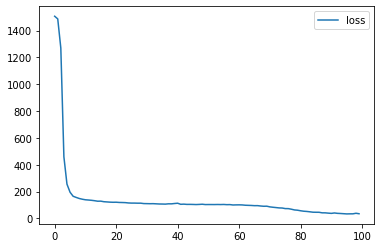

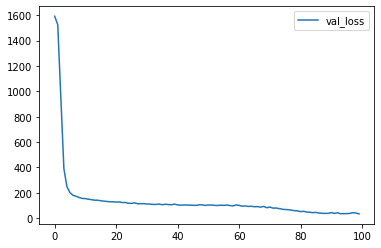

In [20]:
history = pd.DataFrame(history.history)
history.loc[:, ['loss']].plot();
history.loc[:, ['val_loss']].plot();

In [22]:
y_pred = model1.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/7 [==============================] - 0s 2ms/step


In [23]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.835102601784266

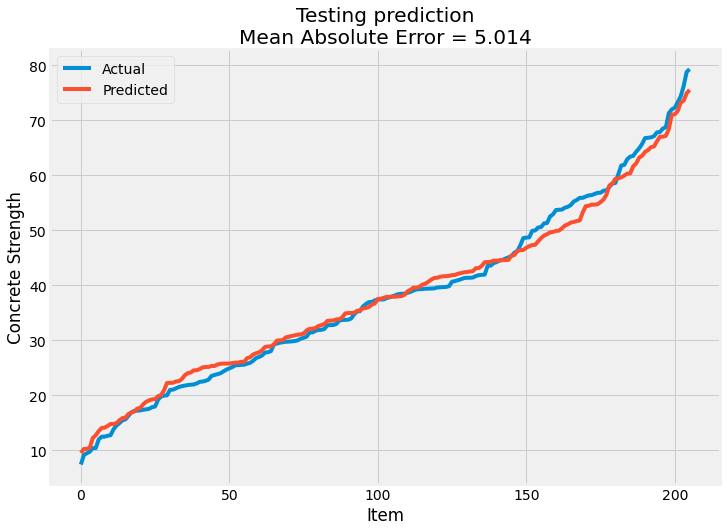

In [24]:
MAE = mae(y_test,y_pred)

plt.figure(figsize=(12,8))
with plt.style.context('fivethirtyeight'):

    plt.plot(sorted(y_test), label='Actual')
    plt.plot(sorted(y_pred), label='Predicted')
#     plt.fill_between(x=np.arange(0,len(y_pred)),
#                      y1=np.array(sorted(y_pred)+MAE),
#                      y2=sorted(y_pred)-MAE, 
#                      alpha=0.1, color='r', label='MAE')

    plt.title('Testing prediction\nMean Absolute Error = {:.3f}'.format(MAE))
    plt.ylabel('Concrete Strength')
    plt.xlabel('Item')
    plt.legend()
plt.show()

## Model Finetuning 

## Improving with different archtitecture

In [ ]:
model2 = keras.Sequential([
    Dense(40 , activation = 'relu' , input_shape = [X_train.shape[1]]),
    Dense(50 , activation = 'relu'),
    Dense(60 , activation = 'relu'),
    Dense(1 , activation = 'linear')
])

In [ ]:
# summary of the model
model2.summary()

In [ ]:
model2.compile(optimizer='Adam', loss = 'mean_squared_error' , )

In [ ]:
history = model2.fit(X_train,y_train,batch_size=62 , epochs=100 , validation_split=.1,verbose = 1)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot();
history_df.loc[:, ['val_loss']].plot();

## Prediction on Unseen Data

In [ ]:
y_pred = model2.predict(X_test)

## Model Evaluation 

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

In [ ]:
MAE = mae(y_test,y_pred)

plt.figure(figsize=(12,8))
with plt.style.context('fivethirtyeight'):

    plt.plot(sorted(y_test), label='Actual')
    plt.plot(sorted(y_pred), label='Predicted')
#     plt.fill_between(x=np.arange(0,len(y_pred)),
#                      y1=np.array(sorted(y_pred)+MAE),
#                      y2=sorted(y_pred)-MAE, 
#                      alpha=0.1, color='r', label='MAE')

    plt.title('Testing prediction\nMean Absolute Error = {:.3f}'.format(MAE))
    plt.ylabel('Concrete Strength')
    plt.xlabel('Item')
    plt.legend()
plt.show()

## Improving ANN with Dropout layer

In [ ]:
model3 = keras.Sequential([
    Dense(30 , activation = 'relu' , input_shape = [X_train.shape[1]]),
    Dense(40 , activation = 'relu'),
    Dropout(rate = 0.1),
    Dense(50 , activation = 'relu'),
    Dense(1 , activation = 'linear')
])



In [ ]:
model3.summary()

In [ ]:
# Compiling the ANN
model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
history = model3.fit(X_train,y_train,
                          batch_size=62 , 
                          epochs=100 , 
                          validation_split=0.1,
                          verbose = 1)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot();
history_df.loc[:, ['val_loss']].plot();

In [ ]:
y_pred = model3.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

In [ ]:
MAE = mae(y_test,y_pred)

plt.figure(figsize=(12,8))
with plt.style.context('fivethirtyeight'):

    plt.plot(sorted(y_test), label='Actual')
    plt.plot(sorted(y_pred), label='Predicted')
#     plt.fill_between(x=np.arange(0,len(y_pred)),
#                      y1=np.array(sorted(y_pred)+MAE),
#                      y2=sorted(y_pred)-MAE, 
#                      alpha=0.1, color='r', label='MAE')

    plt.title('Testing prediction\nMean Absolute Error = {:.3f}'.format(MAE))
    plt.ylabel('Concrete Strength')
    plt.xlabel('Item')
    plt.legend()
plt.show()

# Conclusion 

We trained three ANN model using Different Fine Tuning Technique, from all the three models 2nd model is giving better performance so will select the second model for Deployment